In [22]:
import tensorflow as tf 
from tensorflow import keras
import os 
import numpy as np 
import matplotlib.pyplot as plt
from glob import glob
import cv2
from scipy import ndimage

from tensorflow.keras.layers import LeakyReLU

import segmentation_models as sm
sm.set_framework('tf.keras')
sm.framework()

'tf.keras'

In [31]:
# base_path = 'D:/Dropbox/2. WORK/SNUH/Atopy Segmentation'
base_path = 'C:/Users/user/Desktop/datasets/Atopy Segmentation'
# path_8 = os.path.join(base_path, 'Intersect_0.8')
paths = ['Intersect_0.75', 'Intersect_0.8', 'Intersect_0.85']
grades = ['Grade0', 'Grade1', 'Grade2', 'Grade3']

path = paths[0]
grade = grades[3]
# N_RES = 256

In [32]:
x_train = {}
y_train = {}

x_test = {}
y_test = {}

x_extra = {}
y_extra = {} 


# for path in paths:  
# for grade in grades:
x_train_list = glob(os.path.join(base_path, path, 'Atopy_Segment_Train', f'{grade}/*.jpg'))
y_train_list = glob(os.path.join(base_path, path, 'Atopy_Segment_Train', f'{grade}/*.png'))

x_test_list = glob(os.path.join(base_path, path, 'Atopy_Segment_Test', f'{grade}/*.jpg'))
y_test_list = glob(os.path.join(base_path, path, 'Atopy_Segment_Test', f'{grade}/*.png'))

x_extra_list = glob(os.path.join(base_path, path, 'Atopy_Segment_Extra', f'{grade}/*.jpg'))
y_extra_list = glob(os.path.join(base_path, path, 'Atopy_Segment_Extra', f'{grade}/*.png'))

In [33]:
N_RES = 256  
train_images = [] 
train_labels = [] 
none_mask = 0 
none_data = 0 

for x in x_train_list:
    img = cv2.imread(x, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (N_RES, N_RES))
    img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
    img = np.float32(img)
    
    y = x[:-4] + '.png'
    # print(y)

    # if lbl is None:
    if os.path.isfile(y) == False:
        print(f'Not found mask file : {x}') 
        none_mask += 1
        continue
    
    lbl = cv2.imread(y, cv2.COLOR_BGR2GRAY)
    lbl = cv2.resize(lbl, (N_RES, N_RES))
    lbl = cv2.normalize(lbl, None, 0, 255, cv2.NORM_MINMAX)
    lbl = np.float32(lbl)
    
    train_images.append(img) 
    train_labels.append(lbl) 
    # 
train_images = np.reshape(train_images, [-1, N_RES, N_RES, 3])
train_labels = np.reshape(train_labels, [-1, N_RES, N_RES, 1])
    

Not found mask file : C:/Users/user/Desktop/datasets/Atopy Segmentation\Intersect_0.75\Atopy_Segment_Train\Grade3\3367.jpg
Not found mask file : C:/Users/user/Desktop/datasets/Atopy Segmentation\Intersect_0.75\Atopy_Segment_Train\Grade3\3445.jpg
Not found mask file : C:/Users/user/Desktop/datasets/Atopy Segmentation\Intersect_0.75\Atopy_Segment_Train\Grade3\5114.jpg


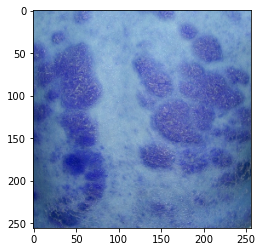

In [34]:
# train_images[0]
plt.imshow(train_images[0]/ 255.)

In [35]:
train_images[0]

array([[[113., 156., 193.],
        [109., 152., 187.],
        [108., 152., 184.],
        ...,
        [125., 167., 208.],
        [120., 164., 208.],
        [122., 166., 210.]],

       [[115., 156., 194.],
        [106., 149., 184.],
        [103., 147., 180.],
        ...,
        [123., 166., 205.],
        [130., 173., 212.],
        [123., 169., 208.]],

       [[115., 156., 194.],
        [109., 152., 187.],
        [110., 154., 190.],
        ...,
        [125., 167., 203.],
        [130., 173., 208.],
        [128., 170., 207.]],

       ...,

       [[ 47.,  78., 129.],
        [ 48.,  79., 129.],
        [ 60.,  92., 137.],
        ...,
        [ 51.,  85., 116.],
        [ 60.,  91., 115.],
        [ 74.,  99., 123.]],

       [[ 48.,  75., 126.],
        [ 47.,  75., 126.],
        [ 58.,  91., 136.],
        ...,
        [ 54.,  89., 110.],
        [ 82., 113., 128.],
        [115., 140., 152.]],

       [[ 44.,  71., 125.],
        [ 47.,  74., 125.],
        [ 47.,  

In [36]:
test_images = [] 
test_labels = [] 
none_mask = 0 
none_data = 0 

for x in x_test_list:
    img = cv2.imread(x, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (N_RES, N_RES))
    img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
    img = np.float32(img)
    
    y = x[:-4] + '.png'

    if os.path.isfile(y) == False:
        print(f'Not found mask file : {x}') 
        none_mask += 1
        continue
    
    lbl = cv2.imread(y, cv2.COLOR_BGR2GRAY)
    lbl = cv2.resize(lbl, (N_RES, N_RES))
    lbl = cv2.normalize(lbl, None, 0, 255, cv2.NORM_MINMAX)
    lbl = np.float32(lbl)
    
    test_images.append(img) 
    test_labels.append(lbl) 
    
test_images = np.reshape(test_images, [-1, N_RES, N_RES, 3])
test_labels = np.reshape(test_labels, [-1, N_RES, N_RES, 1])

Not found mask file : C:/Users/user/Desktop/datasets/Atopy Segmentation\Intersect_0.75\Atopy_Segment_Test\Grade3\7408.jpg


(1, 0)

In [40]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

from IPython.display import clear_output

def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

In [37]:
BACKBONE = 'inceptionv3'
preprocess_input = sm.get_preprocessing(BACKBONE)

# preprocess input
train_images = preprocess_input(train_images)
test_images = preprocess_input(test_images)

model = sm.Unet(BACKBONE, encoder_weights='imagenet')

model.compile(
    'Adam',
    loss=sm.losses.bce_jaccard_loss,
    metrics=[sm.metrics.iou_score,],
)

# fit model
# if you use data generator use model.fit_generator(...) instead of model.fit(...)
# more about `fit_generator` here: https://keras.io/models/sequential/#fit_generator
hist = model.fit(train_images, 
                 train_labels,
                 batch_size=16,
                 epochs=100,
                 validation_split=0.3,
                #    validation_data=valid_ds,   
                )

Epoch 1/100
10/10 [==============================] - 7s 443ms/step - loss: -130.7776 - iou_score: 1.9307 - val_loss: 899586.6875 - val_iou_score: 0.1650
Epoch 2/100
10/10 [==============================] - 1s 128ms/step - loss: -367.1449 - iou_score: 4.4752 - val_loss: 107509104.0000 - val_iou_score: 0.1797
Epoch 3/100
10/10 [==============================] - 1s 128ms/step - loss: -566.2897 - iou_score: 5.4748 - val_loss: 95808808.0000 - val_iou_score: 6.5701e-05
Epoch 4/100
10/10 [==============================] - 1s 128ms/step - loss: -733.0230 - iou_score: 7.5474 - val_loss: 3898177536.0000 - val_iou_score: 0.0030
Epoch 5/100
10/10 [==============================] - 1s 128ms/step - loss: -871.4692 - iou_score: 8.6482 - val_loss: 294412608.0000 - val_iou_score: 0.0055
Epoch 6/100
10/10 [==============================] - 1s 128ms/step - loss: -1015.9778 - iou_score: 9.9606 - val_loss: 1105922304.0000 - val_iou_score: 0.0092
Epoch 7/100
10/10 [==============================] - 1s 128ms

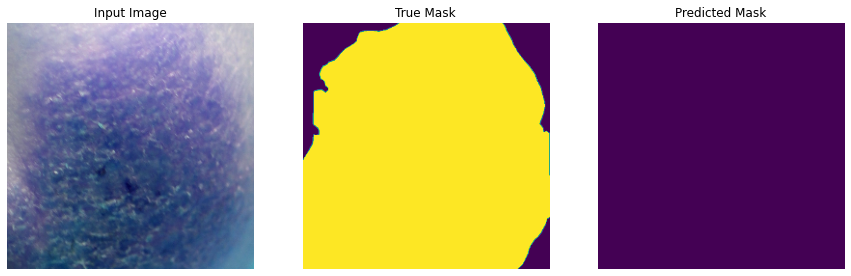

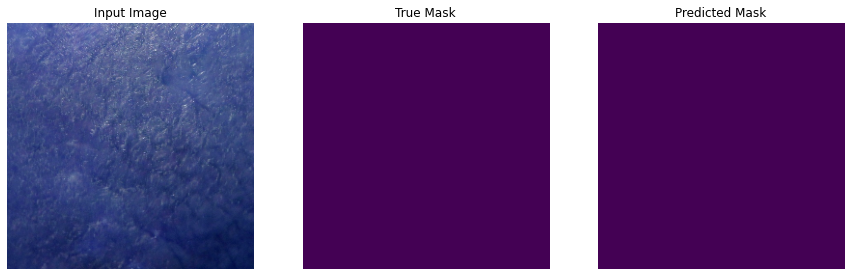

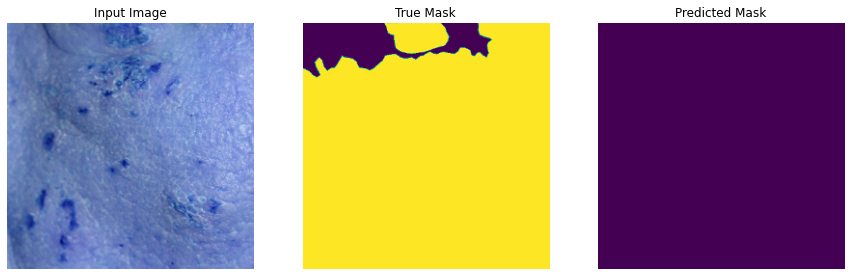

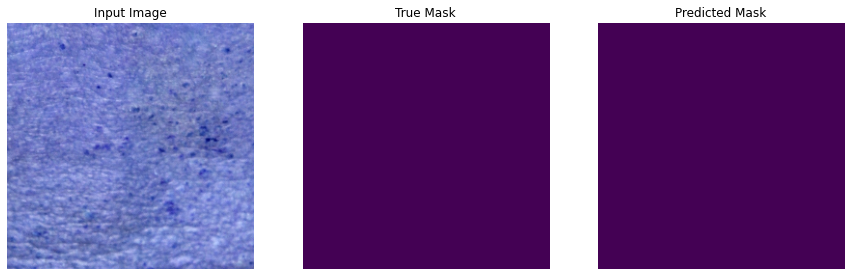

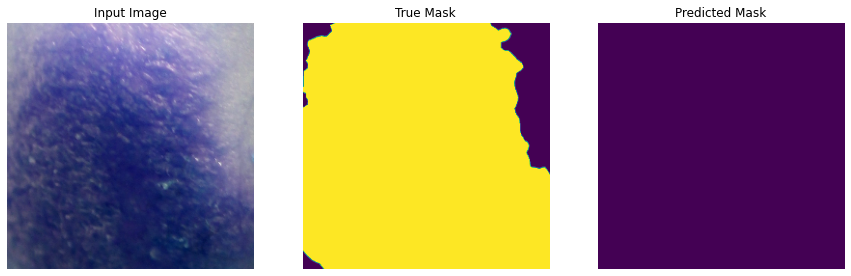

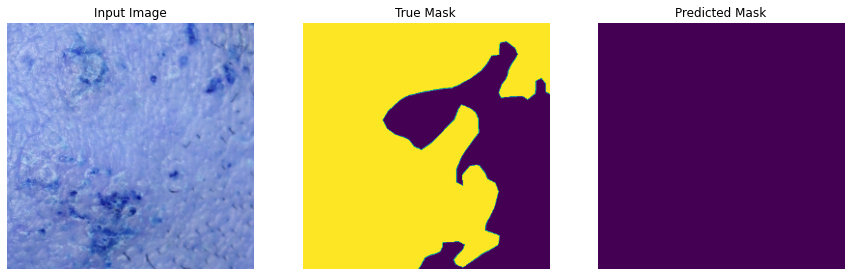

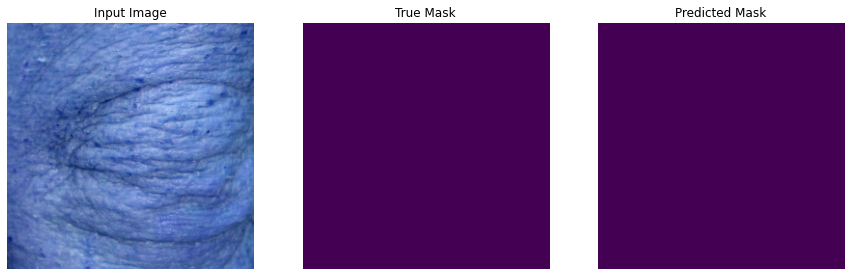

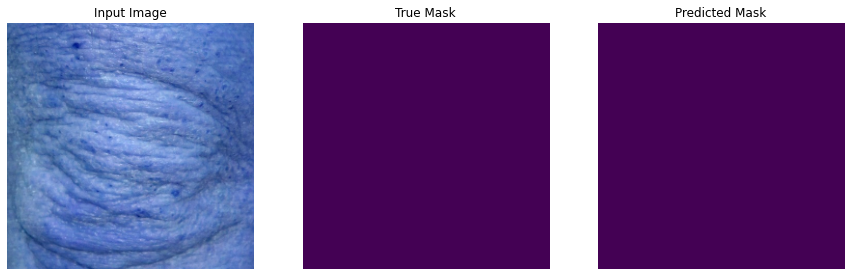

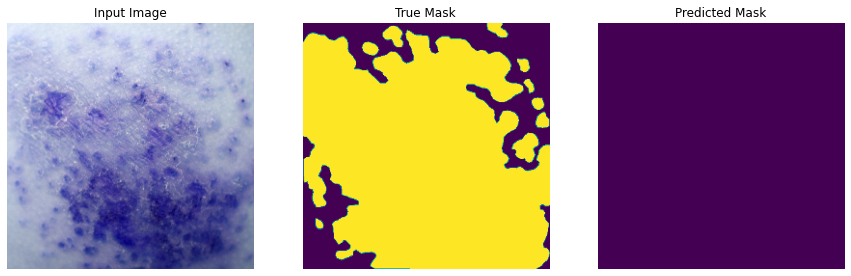

In [43]:
for i in range(6, 15):
    sample_img = test_images[i]
    sample_lbl = test_labels[i]

    display([sample_img, sample_lbl, create_mask(model.predict(sample_img[tf.newaxis, ...]))])
            
    plt.show()

In [49]:
N_RES = 256  
train_images = [] 
train_labels = [] 
none_mask = 0 
none_data = 0 

for x in x_train_list:
    img = cv2.imread(x, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (N_RES, N_RES))
    img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
    img = np.float32(img)
    
    y = x[:-4] + '.png'
    # print(y)

    # if lbl is None:
    if os.path.isfile(y) == False:
        print(f'Not found mask file : {x}') 
        none_mask += 1
        continue
    
    lbl = cv2.imread(y, cv2.COLOR_BGR2GRAY)
    lbl = cv2.resize(lbl, (N_RES, N_RES))
    lbl = cv2.normalize(lbl, None, 0, 255, cv2.NORM_MINMAX)
    lbl = np.float32(lbl)
    
    train_images.append(img) 
    train_labels.append(lbl) 
    # 
train_images = np.reshape(train_images, [-1, N_RES, N_RES, 3])
train_labels = np.reshape(train_labels, [-1, N_RES, N_RES, 1])

test_images = [] 
test_labels = [] 
none_mask = 0 
none_data = 0 

for x in x_test_list:
    img = cv2.imread(x, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (N_RES, N_RES))
    img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
    img = np.float32(img)
    
    y = x[:-4] + '.png'

    if os.path.isfile(y) == False:
        print(f'Not found mask file : {x}') 
        none_mask += 1
        continue
    
    lbl = cv2.imread(y, cv2.COLOR_BGR2GRAY)
    lbl = cv2.resize(lbl, (N_RES, N_RES))
    lbl = cv2.normalize(lbl, None, 0, 255, cv2.NORM_MINMAX)
    lbl = np.float32(lbl)
        
    # if (lbl == 0).sum() < 1:
    #     # print(f'Not found something : {x}')
    #     none_data += 1 
    #     continue
    
    # lbl = cv2.resize(lbl, (N_RES, N_RES))
    # # lbl = cv2.normalize(lbl, None, 0, 255, cv2.NORM_MINMAX)
    # # lbl = np.float32(lbl)
    # lbl = lbl.astype('float')
    
    test_images.append(img) 
    test_labels.append(lbl) 
    
test_images = np.reshape(test_images, [-1, N_RES, N_RES, 3])
test_labels = np.reshape(test_labels, [-1, N_RES, N_RES, 1])

Not found mask file : C:/Users/user/Desktop/datasets/Atopy Segmentation\Intersect_0.75\Atopy_Segment_Train\Grade3\3367.jpg
Not found mask file : C:/Users/user/Desktop/datasets/Atopy Segmentation\Intersect_0.75\Atopy_Segment_Train\Grade3\3445.jpg
Not found mask file : C:/Users/user/Desktop/datasets/Atopy Segmentation\Intersect_0.75\Atopy_Segment_Train\Grade3\5114.jpg
Not found mask file : C:/Users/user/Desktop/datasets/Atopy Segmentation\Intersect_0.75\Atopy_Segment_Test\Grade3\7408.jpg


In [50]:
BACKBONE = 'efficientnetb7'
preprocess_input = sm.get_preprocessing(BACKBONE)

# preprocess input
train_images = preprocess_input(train_images)
test_images = preprocess_input(test_images)

model = sm.Unet(BACKBONE, encoder_weights='imagenet')

model.compile(
    'Adam',
    loss=sm.losses.bce_jaccard_loss,
    metrics=[sm.metrics.iou_score,
            #  'accuracy',
            #  'val_accuracy'
             ],
)

# fit model
# if you use data generator use model.fit_generator(...) instead of model.fit(...)
# more about `fit_generator` here: https://keras.io/models/sequential/#fit_generator
hist = model.fit(train_images, 
                 train_labels,
                 batch_size=16,
                 epochs=100,
                 validation_split=0.3,
                #    validation_data=valid_ds,   
                )

Epoch 1/100
10/10 [==============================] - 23s 1s/step - loss: -115.5889 - iou_score: 1.8511 - val_loss: -18107.5137 - val_iou_score: 178.3960
Epoch 2/100
10/10 [==============================] - 6s 606ms/step - loss: -303.2978 - iou_score: 3.0630 - val_loss: -82710.5078 - val_iou_score: 116.4696
Epoch 3/100
10/10 [==============================] - 6s 624ms/step - loss: -513.1326 - iou_score: 4.9533 - val_loss: -21129.7188 - val_iou_score: 21.2363
Epoch 4/100
10/10 [==============================] - 6s 619ms/step - loss: -724.7192 - iou_score: 5.1293 - val_loss: -37682.6406 - val_iou_score: 38.7520
Epoch 5/100
10/10 [==============================] - 6s 640ms/step - loss: -901.2189 - iou_score: 7.2638 - val_loss: 19965.1543 - val_iou_score: 0.1199
Epoch 6/100
10/10 [==============================] - 6s 625ms/step - loss: -1122.9683 - iou_score: 8.2208 - val_loss: -599.1925 - val_iou_score: 2.1391
Epoch 7/100
10/10 [==============================] - 6s 632ms/step - loss: -1305

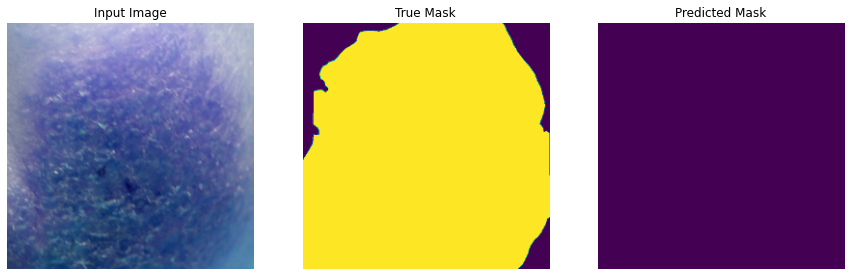

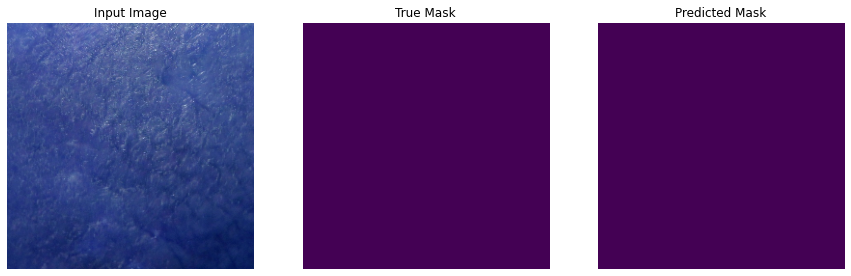

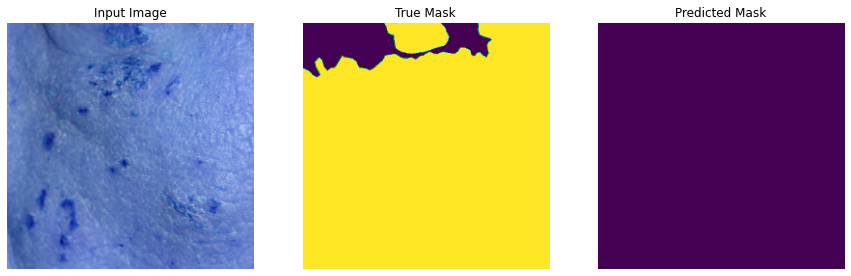

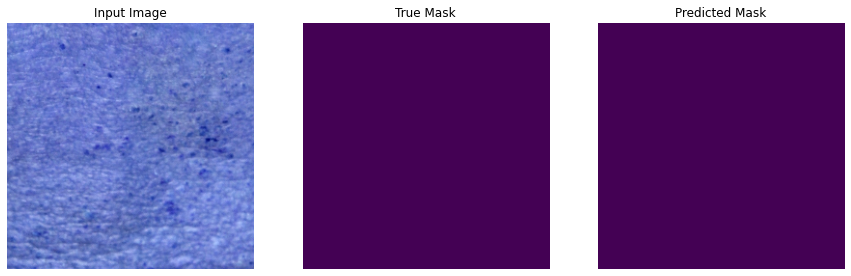

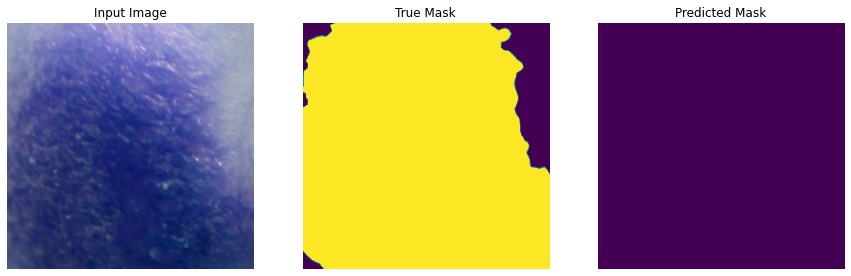

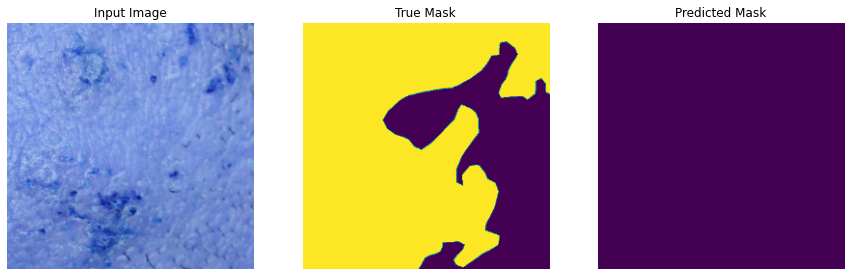

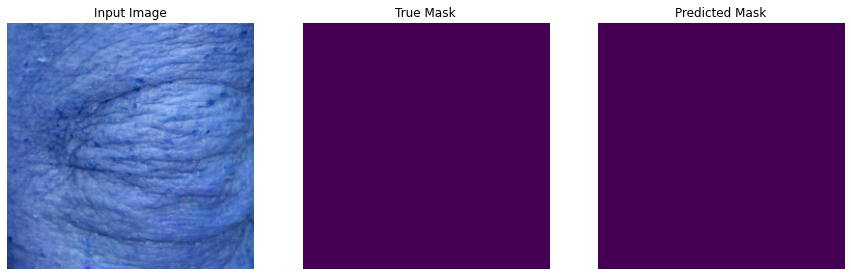

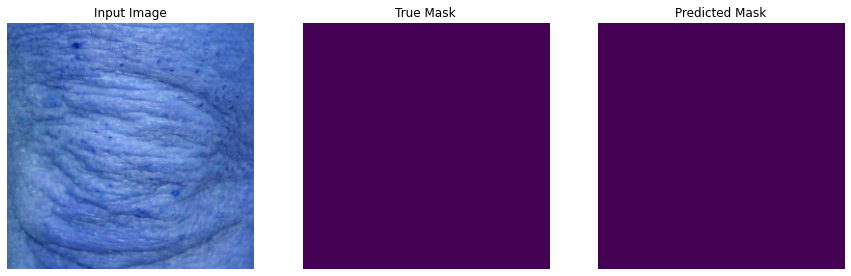

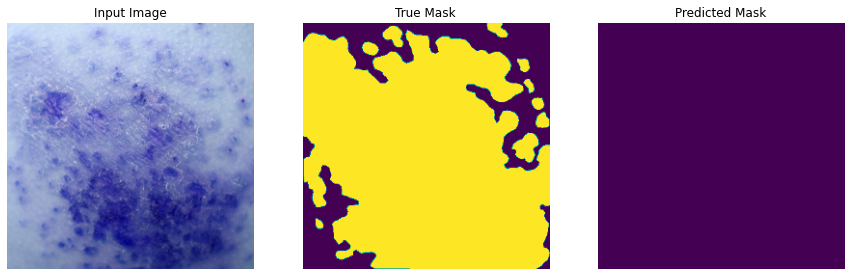

In [51]:
for i in range(6, 15):
    sample_img = test_images[i]
    sample_lbl = test_labels[i]

    display([sample_img, sample_lbl, create_mask(model.predict(sample_img[tf.newaxis, ...]))])
            
    plt.show()

In [61]:
# preprocess input
train_images = preprocess_input(train_images)
test_images = preprocess_input(test_images)


In [64]:
# model = sm.Unet('efficientnetb4', input_shape=(N_RES, N_RES, 3), classes=1, activation='sigmoid', encoder_weights='imagenet')
# model = sm.Unet('efficientnetb4', input_shape=(N_RES, N_RES, 3), classes=1, activation='sigmoid', encoder_weights=None)
model = sm.Unet(BACKBONE, encoder_weights='imagenet')


In [37]:
# define model
# model = sm.Unet(BACKBONE, encoder_weights='imagenet')
model.compile(
    'Adam',
    loss=sm.losses.bce_jaccard_loss,
    metrics=[sm.metrics.iou_score,
            #  'accuracy',
            #  'val_accuracy'
             ],
)

# fit model
# if you use data generator use model.fit_generator(...) instead of model.fit(...)
# more about `fit_generator` here: https://keras.io/models/sequential/#fit_generator
hist = model.fit(train_images, 
                 train_labels,
                 batch_size=16,
                 epochs=100,
                 validation_split=0.3,
                #    validation_data=valid_ds,   
                )

Epoch 1/100
5/5 [==============================] - 20s 1s/step - loss: 75.9384 - iou_score: 0.6686 - val_loss: 327.5581 - val_iou_score: 0.2897
Epoch 2/100
5/5 [==============================] - 1s 290ms/step - loss: -3.0227 - iou_score: 1.0232 - val_loss: 6807.4746 - val_iou_score: 0.2056
Epoch 3/100
5/5 [==============================] - 1s 288ms/step - loss: -81.5182 - iou_score: 1.5069 - val_loss: 13055.5166 - val_iou_score: 0.0479
Epoch 4/100
5/5 [==============================] - 1s 296ms/step - loss: -187.8905 - iou_score: 2.5270 - val_loss: -1154.3947 - val_iou_score: 1.7698
Epoch 5/100
5/5 [==============================] - 1s 292ms/step - loss: -277.0049 - iou_score: 3.9366 - val_loss: -1810.2825 - val_iou_score: 0.9303
Epoch 6/100
5/5 [==============================] - 1s 288ms/step - loss: -346.5224 - iou_score: 6.1289 - val_loss: -5950.0049 - val_iou_score: 4.1176
Epoch 7/100
5/5 [==============================] - 1s 284ms/step - loss: -411.4131 - iou_score: 6.2594 - val_l

In [38]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [49]:
from IPython.display import clear_output

def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

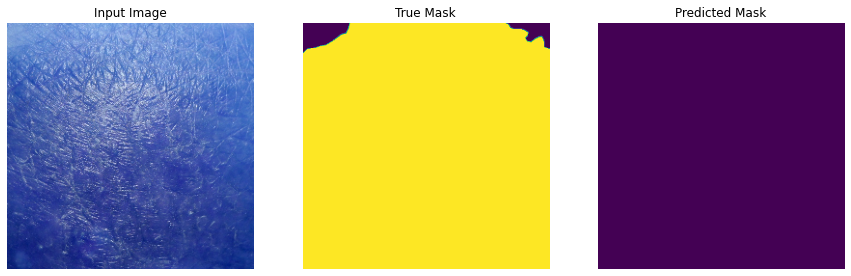

In [56]:
sample_img = test_images[2]
sample_lbl = test_labels[2]

# def show_predictions(dataset=None, num=1):
#     if dataset:
#         for image, mask in dataset.take(num):
#             pred_mask = model.predict(image)
#             display([image[0], mask[0], create_mask(pred_mask)])
#     else:
#         display([test_images[0], test_labels[0], create_mask(model.predict(test_images[0][tf.newaxis, ...]))])

display([sample_img, sample_lbl, create_mask(model.predict(sample_img[tf.newaxis, ...]))])
# display([test_images[0], test_labels[0], create_mask(model.predict(test_images[0][tf.newaxis, ...]))])
# display([test_images[0], test_labels[0], create_mask(model.predict(test_images[0][tf.newaxis, ...]))])
        
plt.show()

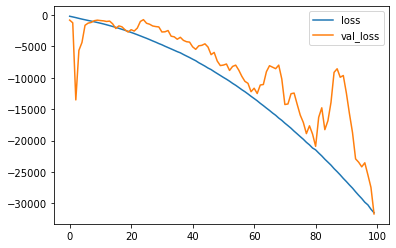

In [12]:
# plt.plot(hist.history['accuracy'], label = "accuracy")
plt.plot(hist.history['loss'], label = "loss")
plt.plot(hist.history['val_loss'], label = "val_loss")
plt.legend()
plt.show()

In [187]:
model.evaluate(test_images)

85/85 [==============================] - 4s 6ms/step - loss: 0.0000e+00 - iou_score: 0.0000e+00


[0.0, 0.0]

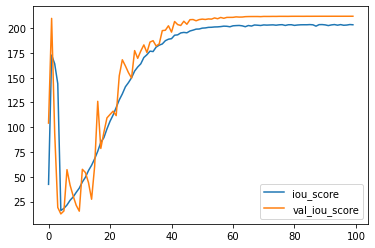

In [189]:

plt.plot(hist.history['iou_score'], label = "iou_score")
plt.plot(hist.history['val_iou_score'], label = "val_iou_score")
# plt.legend(loc = "uppder left")
plt.legend()
plt.show()

In [114]:
from tensorflow.keras import layers

def get_model():
    inputs = keras.Input((N_RES, N_RES, 3))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(1, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model

In [115]:
def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    x = BatchNormalization()(x)
    if activation == True:
        x = LeakyReLU(alpha=0.1)(x)
    return x

def residual_block(blockInput, num_filters=16):
    x = LeakyReLU(alpha=0.1)(blockInput)
    x = BatchNormalization()(x)
    blockInput = BatchNormalization()(blockInput)
    x = convolution_block(x, num_filters, (3,3) )
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    return x

In [116]:
from tensorflow.keras.layers import LeakyReLU, MaxPooling2D, Dropout, Conv2D, Conv2DTranspose, BatchNormalization, Add, Concatenate

def get_efficientnet_model(dropout_rate=0.1):
    
    
    base_model = keras.applications.EfficientNetB4(include_top=False, input_shape=(N_RES, N_RES, 3),  weights = 'imagenet')
    
    # inputs = keras.Input((N_RES, N_RES, 3))
    inputs = base_model.input
    
    start_neurons = 16

    conv4 = base_model.layers[342].output
    conv4 = LeakyReLU(alpha=0.1)(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(dropout_rate)(pool4)
    
     # Middle
    convm = Conv2D(start_neurons * 32, (3, 3), activation=None, padding="same")(pool4)
    convm = residual_block(convm,start_neurons * 32)
    convm = residual_block(convm,start_neurons * 32)
    convm = LeakyReLU(alpha=0.1)(convm)
    
    deconv4 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = Concatenate()([deconv4, conv4])
    uconv4 = Dropout(dropout_rate)(uconv4)
    
    uconv4 = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = residual_block(uconv4,start_neurons * 16)
    uconv4 = residual_block(uconv4,start_neurons * 16)
    uconv4 = LeakyReLU(alpha=0.1)(uconv4)
    
    deconv3 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(uconv4)
    conv3 = base_model.layers[154].output
    uconv3 = Concatenate()([deconv3, conv3])    
    uconv3 = Dropout(dropout_rate)(uconv3)
    
    uconv3 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = residual_block(uconv3,start_neurons * 8)
    uconv3 = residual_block(uconv3,start_neurons * 8)
    uconv3 = LeakyReLU(alpha=0.1)(uconv3)

    deconv2 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv3)
    conv2 = base_model.layers[92].output
    uconv2 = Concatenate()([deconv2, conv2])
        
    uconv2 = Dropout(0.1)(uconv2)
    uconv2 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = residual_block(uconv2,start_neurons * 4)
    uconv2 = residual_block(uconv2,start_neurons * 4)
    uconv2 = LeakyReLU(alpha=0.1)(uconv2)
    
    deconv1 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv2)
    conv1 = base_model.layers[30].output
    uconv1 = Concatenate()([deconv1, conv1])
    
    uconv1 = Dropout(0.1)(uconv1)
    uconv1 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = residual_block(uconv1,start_neurons * 2)
    uconv1 = residual_block(uconv1,start_neurons * 2)
    uconv1 = LeakyReLU(alpha=0.1)(uconv1)
    
    uconv0 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv1)   
    uconv0 = Dropout(0.1)(uconv0)
    uconv0 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv0)
    uconv0 = residual_block(uconv0,start_neurons * 1)
    uconv0 = residual_block(uconv0,start_neurons * 1)
    uconv0 = LeakyReLU(alpha=0.1)(uconv0)
    
    uconv0 = Dropout(dropout_rate/2)(uconv0)
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv0)    
    
    model = tf.keras.Model(input, output_layer)

    return model

In [118]:
model = get_efficientnet_model()

model.compile(loss="mse", 
              optimizer="adam", 
              metrics=["accuracy"])



ValueError: A `Concatenate` layer requires inputs with matching shapes except for the concatenation axis. Received: input_shape=[(None, 16, 16, 128), (None, 336)]

In [ ]:


hist = model.fit(x=train_images,
                 y=train_labels,
                 batch_size=16,
                 epochs=100,
                 validation_split=0.3,
                #    validation_data=(x_val, y_val),   
                )